<a href="https://colab.research.google.com/github/BogaSirichandana/ExplainableAI_Assignments/blob/main/2303a52004_XAI_A2_31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Feature Importance Analysis using SHAP

In [ ]:

!pip install shap xgboost seaborn matplotlib scikit-learn pandas numpy --quiet

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import shap
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")
print(f"SHAP version: {shap.__version__}")
print(f"XGBoost version: {XGBClassifier().__class__.__module__}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
SHAP version: 0.48.0
XGBoost version: xgboost.sklearn
Pandas version: 2.2.2
NumPy version: 2.0.2


In [ ]:
# Load the UCI Heart Disease dataset
from ucimlrepo import fetch_ucirepo

# Fetch dataset
heart_disease = fetch_ucirepo(id=45)

# Extract data
X = heart_disease.data.features
y = heart_disease.data.targets

# Display dataset info
print("✅ Dataset loaded successfully!\n")
print("🔹 Features shape:", X.shape)
print("🔹 Targets shape:", y.shape)

print("\n📌 Feature columns:")
for col in X.columns:
    print("-", col)

print("\n🎯 Target column:", list(y.columns)[0])
print("🔑 Unique target values:", y['num'].unique())


✅ Dataset loaded successfully!

🔹 Features shape: (303, 13)
🔹 Targets shape: (303, 1)

📌 Feature columns:
- age
- sex
- cp
- trestbps
- chol
- fbs
- restecg
- thalach
- exang
- oldpeak
- slope
- ca
- thal

🎯 Target column: num
🔑 Unique target values: [0 2 1 3 4]


In [ ]:
!pip install ucimlrepo --quiet

In [ ]:
df = pd.concat([X, y], axis=1)

print("✅ Dataset Overview")
print("🔹 Shape:", df.shape)
print("🔹 Columns:", list(df.columns))

print("\n📌 First 5 rows:")
display(df.head())

print("\nℹ️ Dataset Info:")
df.info()

print("\n❓ Missing Values per Column:")
print(df.isnull().sum().to_string())

print("\n📊 Basic Statistics:")
display(df.describe().T)

✅ Dataset Overview
🔹 Shape: (303, 14)
🔹 Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

📌 First 5 rows:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0



ℹ️ Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB

❓ Missing Values per Column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
tha

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.438944,9.038662,29.0,48.0,56.0,61.0,77.0
sex,303.0,0.679868,0.467299,0.0,0.0,1.0,1.0,1.0
cp,303.0,3.158416,0.960126,1.0,3.0,3.0,4.0,4.0
trestbps,303.0,131.689769,17.599748,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.693069,51.776918,126.0,211.0,241.0,275.0,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.990099,0.994971,0.0,0.0,1.0,2.0,2.0
thalach,303.0,149.607261,22.875003,71.0,133.5,153.0,166.0,202.0
exang,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [ ]:
# Handle missing values and convert target to binary classification
print("⚙️ Handling missing values and preprocessing...\n")

# Check missing values before handling
print("❓ Missing values before handling:")
print(df.isnull().sum().to_string())

# Fill missing values with mode
df['ca'].fillna(df['ca'].mode()[0], inplace=True)
df['thal'].fillna(df['thal'].mode()[0], inplace=True)

print("\n✅ Missing values filled:")
print(f"- ca → {df['ca'].mode()[0]}")
print(f"- thal → {df['thal'].mode()[0]}")

# Convert target to binary classification (0 = no disease, 1 = disease present)
df['target'] = (df['num'] > 0).astype(int)

print("\n🎯 Target variable distribution:")
print(df['target'].value_counts().to_string())

print("\n📊 Target distribution (percentage):")
print((df['target'].value_counts(normalize=True) * 100).round(2).to_string())

# Check missing values after handling
print("\n❌ Missing values after handling:")
print(df.isnull().sum().to_string())


⚙️ Handling missing values and preprocessing...

❓ Missing values before handling:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0

✅ Missing values filled:
- ca → 0.0
- thal → 3.0

🎯 Target variable distribution:
target
0    164
1    139

📊 Target distribution (percentage):
target
0    54.13
1    45.87

❌ Missing values after handling:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
target      0


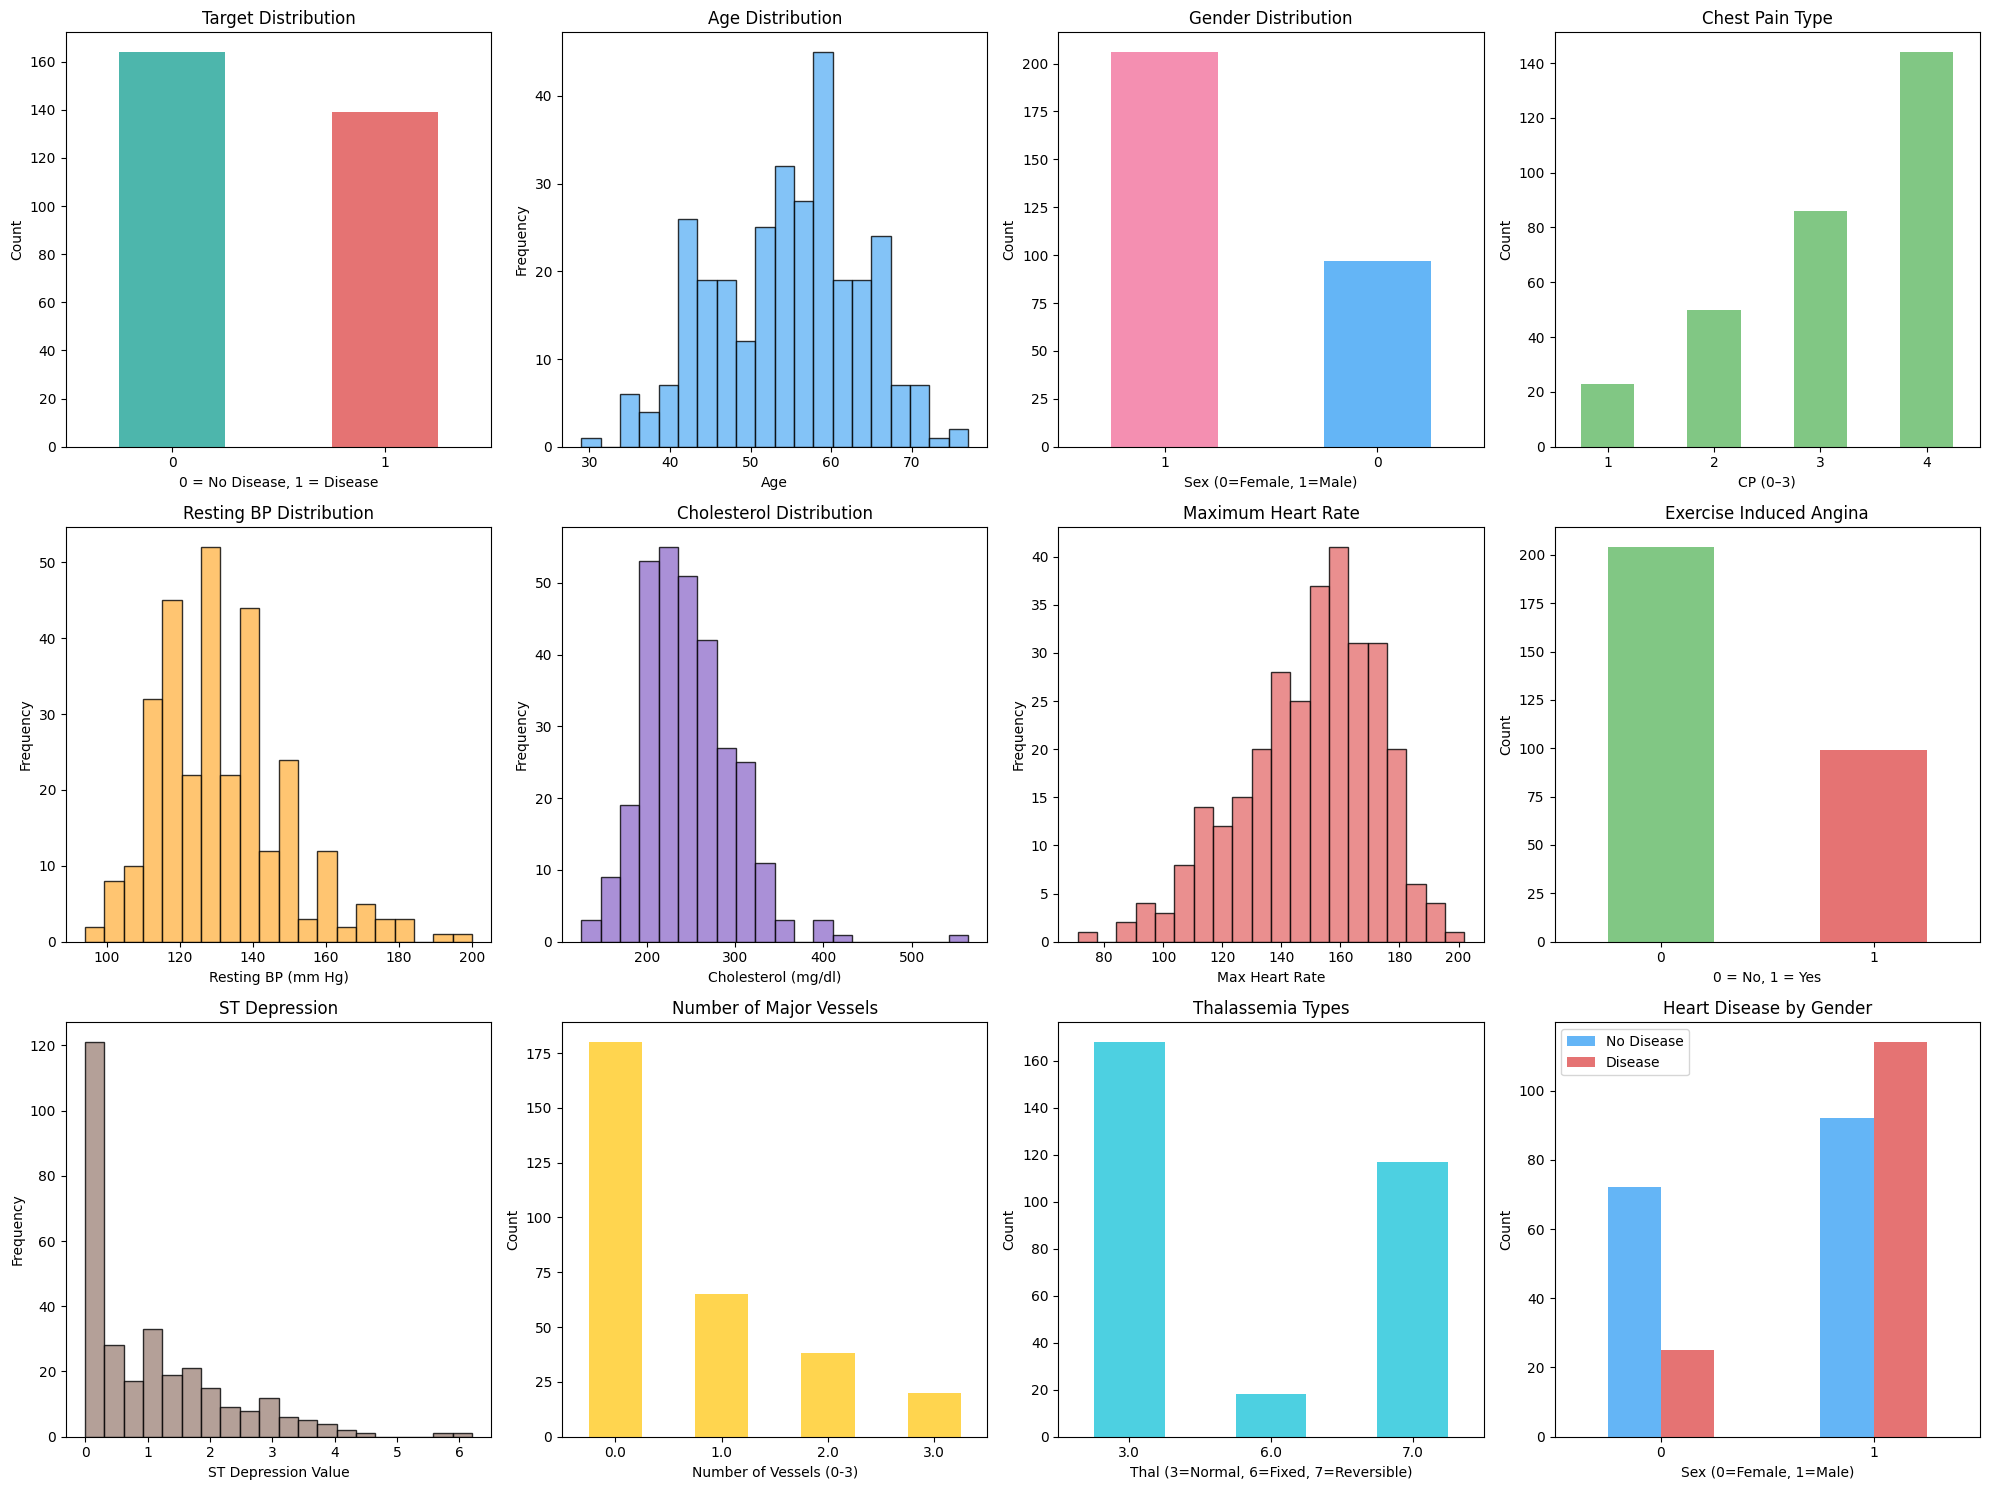

In [ ]:
# Create visualizations for data exploration
plt.figure(figsize=(20, 15))

# 1. Target distribution
plt.subplot(3, 4, 1)
df['target'].value_counts().plot(kind='bar', color=['#4DB6AC', '#E57373'])
plt.title('Target Distribution')
plt.xlabel('0 = No Disease, 1 = Disease')
plt.ylabel('Count')
plt.xticks(rotation=0)

# 2. Age distribution
plt.subplot(3, 4, 2)
plt.hist(df['age'], bins=20, alpha=0.8, color='#64B5F6', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

# 3. Gender distribution
plt.subplot(3, 4, 3)
df['sex'].value_counts().plot(kind='bar', color=['#F48FB1', '#64B5F6'])
plt.title('Gender Distribution')
plt.xlabel('Sex (0=Female, 1=Male)')
plt.ylabel('Count')
plt.xticks(rotation=0)

# 4. Chest Pain Type distribution
plt.subplot(3, 4, 4)
df['cp'].value_counts().sort_index().plot(kind='bar', color='#81C784')
plt.title('Chest Pain Type')
plt.xlabel('CP (0–3)')
plt.ylabel('Count')
plt.xticks(rotation=0)

# 5. Resting Blood Pressure
plt.subplot(3, 4, 5)
plt.hist(df['trestbps'], bins=20, alpha=0.8, color='#FFB74D', edgecolor='black')
plt.title('Resting BP Distribution')
plt.xlabel('Resting BP (mm Hg)')
plt.ylabel('Frequency')

# 6. Cholesterol
plt.subplot(3, 4, 6)
plt.hist(df['chol'], bins=20, alpha=0.8, color='#9575CD', edgecolor='black')
plt.title('Cholesterol Distribution')
plt.xlabel('Cholesterol (mg/dl)')
plt.ylabel('Frequency')

# 7. Maximum Heart Rate
plt.subplot(3, 4, 7)
plt.hist(df['thalach'], bins=20, alpha=0.8, color='#E57373', edgecolor='black')
plt.title('Maximum Heart Rate')
plt.xlabel('Max Heart Rate')
plt.ylabel('Frequency')

# 8. Exercise Induced Angina
plt.subplot(3, 4, 8)
df['exang'].value_counts().plot(kind='bar', color=['#81C784', '#E57373'])
plt.title('Exercise Induced Angina')
plt.xlabel('0 = No, 1 = Yes')
plt.ylabel('Count')
plt.xticks(rotation=0)

# 9. ST Depression
plt.subplot(3, 4, 9)
plt.hist(df['oldpeak'], bins=20, alpha=0.8, color='#A1887F', edgecolor='black')
plt.title('ST Depression')
plt.xlabel('ST Depression Value')
plt.ylabel('Frequency')

# 10. Number of Major Vessels
plt.subplot(3, 4, 10)
df['ca'].value_counts().sort_index().plot(kind='bar', color='#FFD54F')
plt.title('Number of Major Vessels')
plt.xlabel('Number of Vessels (0-3)')
plt.ylabel('Count')
plt.xticks(rotation=0)

# 11. Thalassemia
plt.subplot(3, 4, 11)
df['thal'].value_counts().sort_index().plot(kind='bar', color='#4DD0E1')
plt.title('Thalassemia Types')
plt.xlabel('Thal (3=Normal, 6=Fixed, 7=Reversible)')
plt.ylabel('Count')
plt.xticks(rotation=0)

# 12. Heart Disease by Gender
plt.subplot(3, 4, 12)
pd.crosstab(df['sex'], df['target']).plot(
    kind='bar', color=['#64B5F6', '#E57373'], ax=plt.gca()
)
plt.title('Heart Disease by Gender')
plt.xlabel('Sex (0=Female, 1=Male)')
plt.ylabel('Count')
plt.legend(['No Disease', 'Disease'])
plt.xticks(rotation=0)

plt.tight_layout()
plt.savefig('data_exploration.png', dpi=300, bbox_inches='tight')
plt.show()

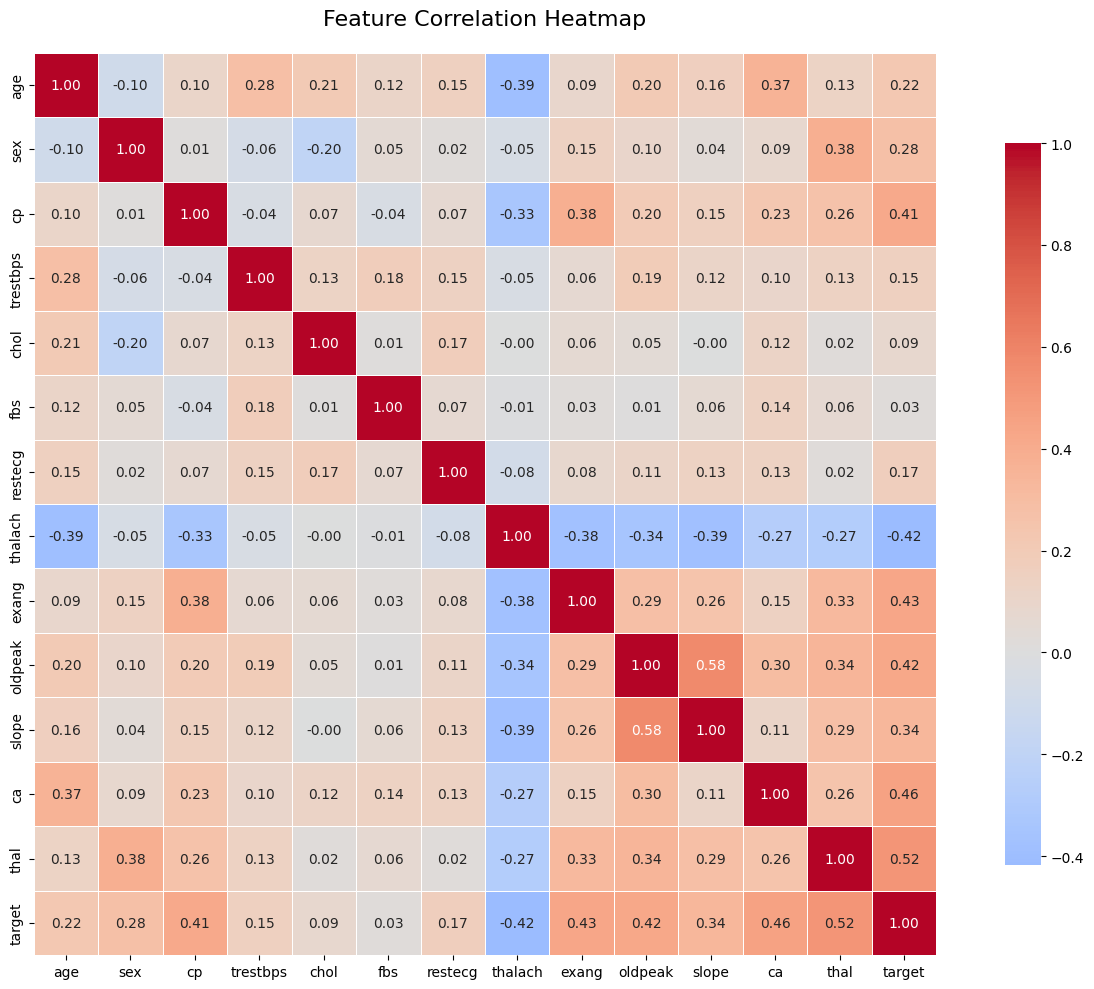


📊 Correlation analysis with Target:
thal        0.522057
ca          0.460033
exang       0.431894
oldpeak     0.424510
thalach    -0.417167
cp          0.414446
slope       0.339213
sex         0.276816
age         0.223120
restecg     0.169202
trestbps    0.150825
chol        0.085164
fbs         0.025264
Name: target, dtype: float64


In [ ]:
# Create correlation heatmap
plt.figure(figsize=(14, 10))

# Select feature columns (excluding 'num' since 'target' is our label)
feature_cols = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

corr_matrix = df[feature_cols].corr()

# Plot heatmap
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    center=0,
    square=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title('Feature Correlation Heatmap', fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Show correlations with target
print("\n📊 Correlation analysis with Target:")
target_corr = corr_matrix['target'].sort_values(key=abs, ascending=False)
print(target_corr.drop('target'))

In [ ]:
# Prepare features and target for modeling
feature_cols = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

X = df[feature_cols].copy()
y = df['target'].copy()

print("✅ Features and Target Prepared\n")
print(f"🔹 X shape: {X.shape}")
print(f"🔹 y shape: {y.shape}")

print("\n📌 Feature columns:")
print(", ".join(X.columns))

print("\n🎯 Target distribution:")
print(y.value_counts().to_string())
print("\n(%) distribution:")
print((y.value_counts(normalize=True) * 100).round(2).to_string())

# Check missing values
print("\n❓ Missing values check:")
print(f"- Features: {X.isnull().sum().sum()}")
print(f"- Target: {y.isnull().sum()}")

# Feature types
print("\n📊 Feature data types:")
print(X.dtypes.to_string())


✅ Features and Target Prepared

🔹 X shape: (303, 13)
🔹 y shape: (303,)

📌 Feature columns:
age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal

🎯 Target distribution:
target
0    164
1    139

(%) distribution:
target
0    54.13
1    45.87

❓ Missing values check:
- Features: 0
- Target: 0

📊 Feature data types:
age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca          float64
thal        float64


In [ ]:
from sklearn.model_selection import train_test_split

# Split data (80-20 split with stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Data Split Completed\n")
print(f"🔹 Training set: X={X_train.shape}, y={y_train.shape}")
print(f"🔹 Testing set:  X={X_test.shape}, y={y_test.shape}")

print("\n📊 Target distribution in Training set:")
print((y_train.value_counts(normalize=True) * 100).round(2).to_string())

print("\n📊 Target distribution in Testing set:")
print((y_test.value_counts(normalize=True) * 100).round(2).to_string())


✅ Data Split Completed

🔹 Training set: X=(242, 13), y=(242,)
🔹 Testing set:  X=(61, 13), y=(61,)

📊 Target distribution in Training set:
target
0    54.13
1    45.87

📊 Target distribution in Testing set:
target
0    54.1
1    45.9


In [ ]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Feature Scaling Completed\n")

# Original ranges (training set)
print("📌 Original feature ranges (Training set):")
print(f"- Min: {X_train.min().min()}")
print(f"- Max: {X_train.max().max()}")

# Scaled ranges
print("\n📊 Scaled feature summary (Training set):")
print(f"- Min: {X_train_scaled.min():.3f}")
print(f"- Max: {X_train_scaled.max():.3f}")
print(f"- Mean: {X_train_scaled.mean():.3f}")
print(f"- Std: {X_train_scaled.std():.3f}")


✅ Feature Scaling Completed

📌 Original feature ranges (Training set):
- Min: 0.0
- Max: 564.0

📊 Scaled feature summary (Training set):
- Min: -3.488
- Max: 5.957
- Mean: -0.000
- Std: 1.000


In [ ]:
# Initialize models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric="logloss"),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000)
}

model_results = {}
trained_models = {}

print("🚀 Training Models")
print("="*55)

for name, model in models.items():
    print(f"\n▶ Training {name}...")

    # Scale only for Logistic Regression
    if name == "Logistic Regression":
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

    # Compute metrics
    results = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1_score": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba),
        "predictions": y_pred,
        "probabilities": y_proba
    }

    model_results[name] = results
    trained_models[name] = model

    print(f"✅ {name} → "
          f"Acc: {results['accuracy']:.3f}, "
          f"F1: {results['f1_score']:.3f}, "
          f"ROC-AUC: {results['roc_auc']:.3f}")

print("\n" + "="*55)
print("🎉 All models trained successfully!")

🚀 Training Models

▶ Training Random Forest...
✅ Random Forest → Acc: 0.885, F1: 0.881, ROC-AUC: 0.952

▶ Training XGBoost...
✅ XGBoost → Acc: 0.852, F1: 0.852, ROC-AUC: 0.919

▶ Training Logistic Regression...
✅ Logistic Regression → Acc: 0.869, F1: 0.867, ROC-AUC: 0.951

🎉 All models trained successfully!


In [ ]:
# Create a comparison DataFrame
results_df = pd.DataFrame(model_results).T.drop(['predictions', 'probabilities'], axis=1)

print("📊 Model Performance Comparison")
print("="*60)
display(results_df.round(4))

# Select best model based on ROC-AUC
best_model_name = results_df['roc_auc'].idxmax()
best_model = trained_models[best_model_name]

print(f"\n🏆 Best Model: {best_model_name}")
print(f"ROC-AUC Score: {results_df.loc[best_model_name, 'roc_auc']:.4f}")

# Detailed classification report for the best model
print(f"\n📝 Classification Report for {best_model_name}")
print("="*60)
y_pred_best = model_results[best_model_name]['predictions']
print(classification_report(y_test, y_pred_best, target_names=['No Disease', 'Disease']))


📊 Model Performance Comparison


,accuracy,precision,recall,f1_score,roc_auc
Random Forest,0.885246,0.83871,0.928571,0.881356,0.95184
XGBoost,0.852459,0.787879,0.928571,0.852459,0.918831
Logistic Regression,0.868852,0.8125,0.928571,0.866667,0.951299



🏆 Best Model: Random Forest
ROC-AUC Score: 0.9518

📝 Classification Report for Random Forest
              precision    recall  f1-score   support

  No Disease       0.93      0.85      0.89        33
     Disease       0.84      0.93      0.88        28

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61



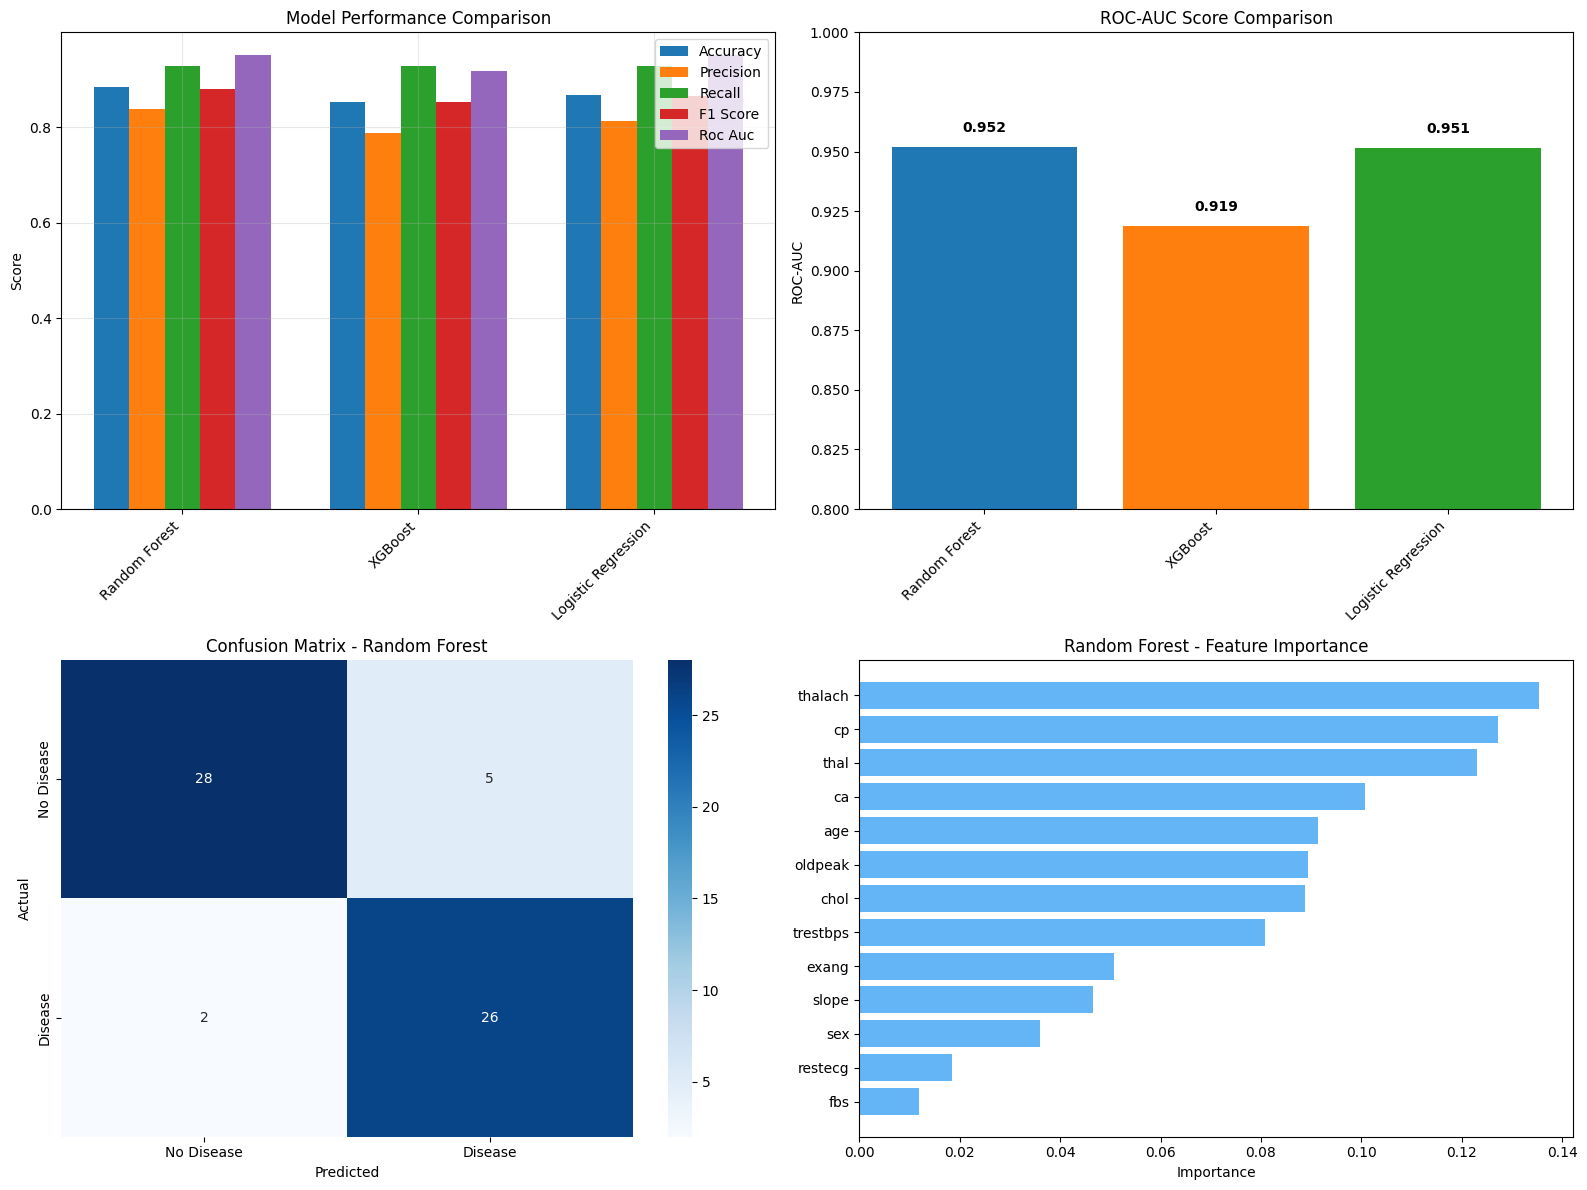

In [ ]:
# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Model Comparison Bar Chart
ax1 = axes[0, 0]
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
x = np.arange(len(results_df.index))
width = 0.15

for i, metric in enumerate(metrics):
    ax1.bar(x + i * width, results_df[metric], width,
            label=metric.replace('_', ' ').title())

ax1.set_xticks(x + width*2)
ax1.set_xticklabels(results_df.index, rotation=45, ha='right')
ax1.set_ylabel('Score')
ax1.set_title('Model Performance Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. ROC-AUC Comparison
ax2 = axes[0, 1]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
bars = ax2.bar(results_df.index, results_df['roc_auc'], color=colors)
ax2.set_ylim(0.8, 1.0)
ax2.set_title('ROC-AUC Score Comparison')
ax2.set_ylabel('ROC-AUC')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# Add value labels
for bar, value in zip(bars, results_df['roc_auc']):
    ax2.text(bar.get_x() + bar.get_width()/2, value + 0.005,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. Confusion Matrix for Best Model
ax3 = axes[1, 0]
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
ax3.set_title(f'Confusion Matrix - {best_model_name}')
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')

# 4. Feature Importance (if applicable)
ax4 = axes[1, 1]
if best_model_name in ['Random Forest', 'XGBoost']:
    feature_importance = best_model.feature_importances_
    feature_names = X.columns
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=True)

    ax4.barh(importance_df['Feature'], importance_df['Importance'], color='#64B5F6')
    ax4.set_title(f'{best_model_name} - Feature Importance')
    ax4.set_xlabel('Importance')
else:
    ax4.text(0.5, 0.5, f'{best_model_name}\nFeature Importance\nNot Available',
             ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Feature Importance')

plt.tight_layout()
plt.savefig('model_performance.png', dpi=300, bbox_inches='tight')
plt.show()


=== SHAP Explanations ===
Generating SHAP explanations for the best model: Random Forest
✅ SHAP values computed successfully!
SHAP values shape: (61, 13)
Expected value: 0.46157024793388446


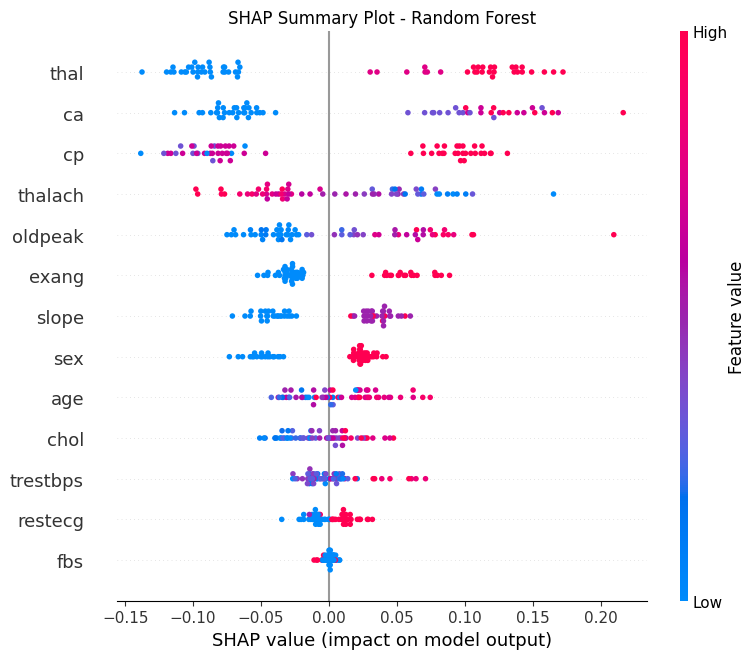

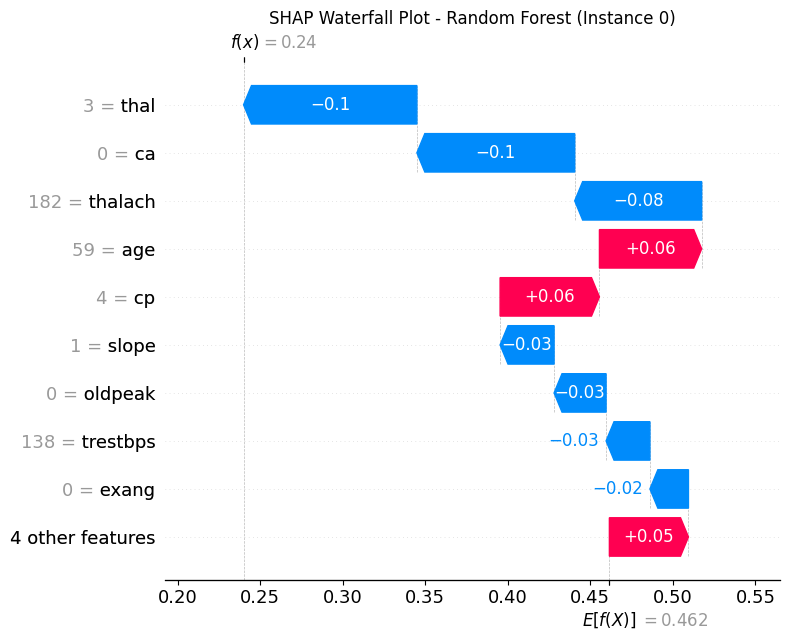

In [ ]:

print("\n=== SHAP Explanations ===")
print(f"Generating SHAP explanations for the best model: {best_model_name}")

# Select explainer based on model type
if best_model_name in ['Random Forest', 'XGBoost']:
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test if best_model_name != 'Logistic Regression' else X_test_scaled)

    # Handle binary classification: take class 1
    if isinstance(shap_values, list):
        shap_values_for_plot = shap_values[1]
        expected_value = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value
    else:
        shap_values_for_plot = shap_values[:, :, 1] if shap_values.ndim == 3 else shap_values
        expected_value = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value

elif best_model_name == 'Logistic Regression':
    explainer = shap.LinearExplainer(best_model, X_train_scaled, feature_dependence="correlation")
    shap_values_for_plot = explainer.shap_values(X_test_scaled)
    expected_value = explainer.expected_value

else:
    explainer = shap.KernelExplainer(best_model.predict_proba, X_train_scaled)
    shap_values_for_plot = explainer.shap_values(X_test_scaled)[1]
    expected_value = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value

print("✅ SHAP values computed successfully!")
print(f"SHAP values shape: {shap_values_for_plot.shape}")
print(f"Expected value: {expected_value}")

# 1. Summary plot - overall feature importance
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_for_plot,
    X_test if best_model_name != 'Logistic Regression' else X_test_scaled,
    feature_names=X.columns,
    show=False
)
plt.title(f'SHAP Summary Plot - {best_model_name}')
plt.tight_layout()
plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Force plot - individual prediction (first test instance)
shap.initjs()
instance_data = X_test.iloc[0] if best_model_name != 'Logistic Regression' else X_test_scaled[0]
explanation = shap.Explanation(
    values=shap_values_for_plot[0],
    base_values=float(expected_value),
    data=instance_data,
    feature_names=X.columns
)
try:
    force_plot = shap.plots.force(explanation, matplotlib=False)
    display(force_plot)
    shap.save_html('shap_force_plot.html', force_plot)
except Exception as e:
    print(f"⚠️ Force plot generation skipped due to error: {e}")

# 3. Waterfall plot - step-by-step feature contribution (first instance)
plt.figure(figsize=(10, 8))
explanation = shap.Explanation(
    values=shap_values_for_plot[0],
    base_values=float(expected_value),
    data=instance_data.values if hasattr(instance_data, 'values') else instance_data,
    feature_names=X.columns
)
try:
    shap.plots.waterfall(explanation, show=False)
    plt.title(f'SHAP Waterfall Plot - {best_model_name} (Instance 0)')
    plt.tight_layout()
    plt.savefig('shap_waterfall_plot.png', dpi=300, bbox_inches='tight')
    plt.show()
except Exception as e:
    print(f"⚠️ Waterfall plot generation skipped due to error: {e}")

In [ ]:
# Compute mean absolute SHAP values for each feature
shap_importance = np.abs(shap_values_for_plot).mean(axis=0)

# Create a DataFrame and sort features by importance
shap_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Mean_Abs_SHAP': shap_importance
}).sort_values('Mean_Abs_SHAP', ascending=False)

print("📊 Top 5 Most Important Features (SHAP):")
display(shap_importance_df.head(5))

📊 Top 5 Most Important Features (SHAP):


,Feature,Mean_Abs_SHAP
12,thal,0.101908
11,ca,0.094215
2,cp,0.091864
7,thalach,0.052706
9,oldpeak,0.050147


In [ ]:
if best_model_name in ['Random Forest', 'XGBoost']:
    # Model’s built-in feature importance
    model_importance = pd.DataFrame({
        'Feature': X.columns,
        'Model_Importance': best_model.feature_importances_
    }).sort_values('Model_Importance', ascending=False)

    print("📊 Top 5 Features by Model Importance:")
    display(model_importance.head(5))

    # Compare with SHAP importance
    comparison_df = pd.merge(
        shap_importance_df.head(5),
        model_importance.head(5),
        on='Feature',
        how='outer'
    )
    print("\n🔍 Comparison: SHAP vs Model Feature Importance (Top 5)")
    display(comparison_df)


📊 Top 5 Features by Model Importance:


,Feature,Model_Importance
7,thalach,0.135404
2,cp,0.127163
12,thal,0.122940
11,ca,0.100811
0,age,0.091327



🔍 Comparison: SHAP vs Model Feature Importance (Top 5)


,Feature,Mean_Abs_SHAP,Model_Importance
0,age,NaN,0.091327
1,ca,0.094215,0.100811
2,cp,0.091864,0.127163
3,oldpeak,0.050147,NaN
4,thal,0.101908,0.122940
5,thalach,0.052706,0.135404
